In [35]:
%load_ext autoreload
%autoreload 2
from decomposer import WaveletDecomposer
from loadsimulation import SimulationDataLoader
from adjustl1 import *
from adjustcls import *

from skimage.transform import downscale_local_mean

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Set global rc parameters for plot appearance
plt.rcParams.update({
    'axes.titlesize': 22,            # Font size for the plot titles
    'axes.labelsize': 20,            # Font size for the x and y labels
    'legend.fontsize': 16,           # Font size for the legend
    'xtick.labelsize': 20,           # Font size for the x-tick labels
    'ytick.labelsize': 20,           # Font size for the y-tick labels
    'axes.linewidth': 3.5,           # Width of the axes' lines
    'xtick.major.width': 3.25,       # Width of the major x-tick lines
    'ytick.major.width': 3.25,       # Width of the major y-tick lines
    'xtick.minor.width': 4.0,        # Width of the minor x-tick lines
    'ytick.minor.width': 4.0,        # Width of the minor y-tick lines
    'figure.titlesize': 20,          # Font size for figure titles
    'legend.handlelength': 2,        # Length of the legend lines
    'legend.handleheight': 0.7,      # Height of the legend markers
    'legend.labelspacing': 0.5,      # Vertical spacing between legend entries
    'lines.linewidth': 3.0,          # Line width for plot lines
    'lines.markersize': 3,           # Size of markers in plot lines
    'axes.grid': False,               # Enable grid on all plots
    'grid.alpha': 0.75,              # Set gridline transparency
    'grid.linestyle': '--',          # Set gridline style
    'grid.linewidth': 0.7,           # Set gridline width
    'grid.color': 'gray',            # Set gridline color
})

import time
from scipy.interpolate import CubicSpline

import numpy as np
import jax.numpy as jnp
# from scipy.fft import rfftfreq, fftfreq

from lenspack.image.transforms import starlet2d
from jax.numpy.fft import ifft2, fftn, ifft2, fftfreq
import scipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Testing the powerspectrum adjuster using a target and a gaussian map

the target pixelsize is:  0.5859375
the target size is:  (1024, 1024)
ell_min:  17.188733853924695
ell_max:  8800.631733209444
 
ell_min:  17.188733853924695
ell_max:  8800.631733209444
 


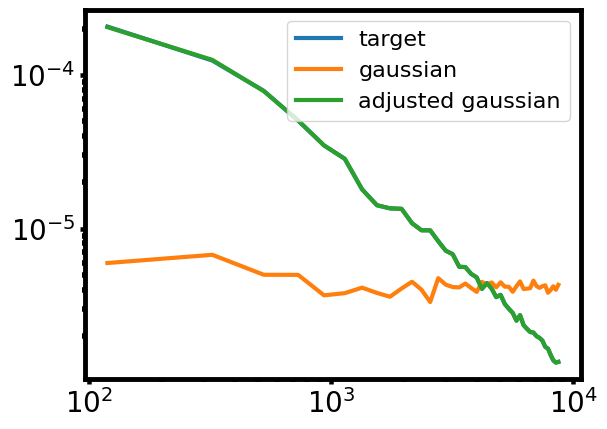

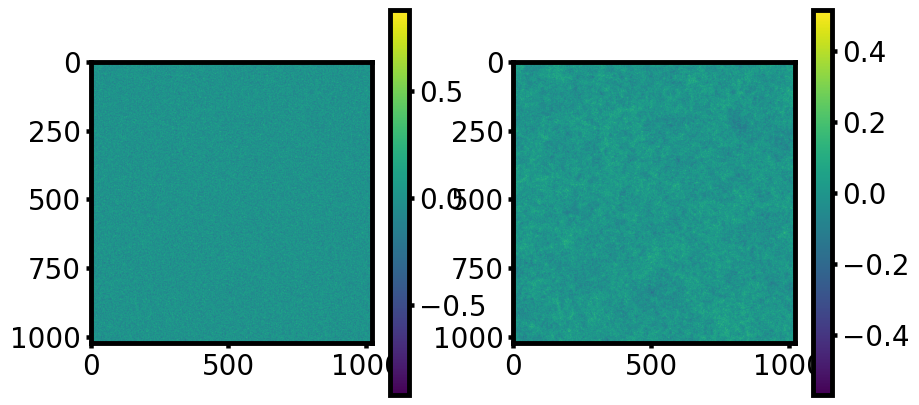

In [73]:
path = '/feynman/work/dap/lcs/vt272285/data/SLICS/2.007kappa_weight.dat_LOS400'
angle = 10
loader = SimulationDataLoader(user_defined_angle=angle) 

loaded_data, loaded_angle = loader.load_data(path)
data_downscaled = downscale_local_mean(loaded_data-np.mean(loaded_data), (4, 4))


N = 256*4
target = data_downscaled[:N,:N]
pixelsize = loaded_angle.value * 60 / target.shape[0]  # arcmin
print("the target pixelsize is: ", pixelsize)
print("the target size is: ", target.shape)

pkadjuster = PowerSpectrum(target, pixelsize)
_, target_ells, target_cls = pkadjuster.calculate_Cls(target)

new_shape = 256*4
gaussian = np.random.normal(0,0.2, (new_shape,new_shape))
pkadjuster = PowerSpectrum(gaussian, pixelsize)

adjusted_gaussian = pkadjuster.generate_field_with_target_cls(gaussian, target_cls, target_ells)
for i in range(5):  
    adjusted_gaussian = pkadjuster.generate_field_with_target_cls(adjusted_gaussian, target_cls, target_ells)

_, gaussian_ells, gaussian_cls = pkadjuster.calculate_Cls(gaussian)
_, adjusted_gaussian_ells, adjusted_gaussian_cls = pkadjuster.calculate_Cls(adjusted_gaussian)

plt.loglog(target_ells, target_cls, label='target')
plt.loglog(gaussian_ells, gaussian_cls, label='gaussian')
plt.loglog(adjusted_gaussian_ells, adjusted_gaussian_cls, label='adjusted gaussian')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(gaussian)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(adjusted_gaussian)
plt.colorbar()
plt.show()


### Testing l1-norm adjustment using a target and a gaussian map

the target pixelsize is:  0.5859375
the target size is:  (1024, 1024)


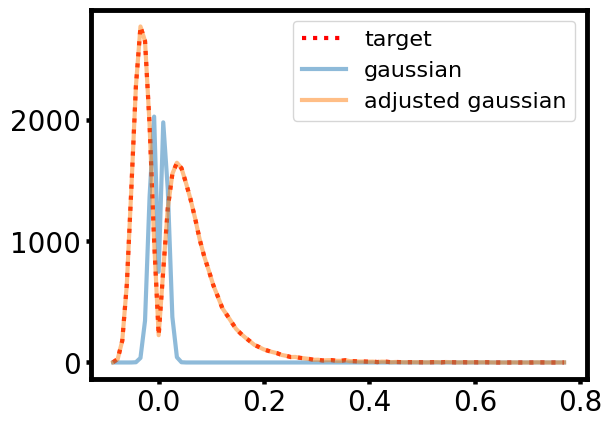

In [31]:
path = '/feynman/work/dap/lcs/vt272285/data/SLICS/2.007kappa_weight.dat_LOS400'
angle = 10
loader = SimulationDataLoader(user_defined_angle=angle) 

loaded_data, loaded_angle = loader.load_data(path)
data_downscaled = downscale_local_mean(loaded_data-np.mean(loaded_data), (4, 4))

N = 1024
target = data_downscaled[:N,:N]
pixelsize = loaded_angle.value * 60 / target.shape[0]  # arcmin
print("the target pixelsize is: ", pixelsize)
print("the target size is: ", target.shape)

gaussian = np.random.normal(0,0.01, (N,N))

target_edges, target_centers, target_hist, target_l1norm = calculate_histogram_l1norm(target, mask=None, nbins=100, density=False)
target_values = {'binedges': target_edges, 'bincenters': target_centers, 'histogram': target_hist, 'l1_norm': target_l1norm}
gaussian_edges, gaussian_centers, gaussian_hist, gaussian_l1norm = calculate_histogram_l1norm(gaussian, mask=None, nbins=target_edges, density=False)

adjusted_gaussian, _ = adjust_map_l1(gaussian, mask=None, targetvalues=target_values)

adjusted_edges, adjusted_centers, adjusted_hist, adjusted_l1norm = calculate_histogram_l1norm(adjusted_gaussian, mask=None, nbins=target_edges)

plt.plot(target_centers, target_l1norm, label='target', ls=":",c='r' )
plt.plot(gaussian_centers, gaussian_l1norm, label='gaussian', alpha=0.5)
plt.plot(adjusted_centers, adjusted_l1norm, label='adjusted gaussian', alpha=0.5)
plt.legend()
plt.show()

the target pixelsize is:  0.5859375
the target size is:  (1024, 1024)


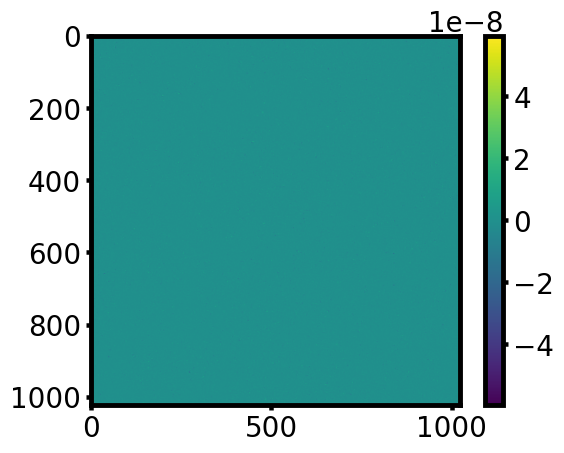

In [72]:
path = '/feynman/work/dap/lcs/vt272285/data/SLICS/2.007kappa_weight.dat_LOS400'
angle = 10
loader = SimulationDataLoader(user_defined_angle=angle) 

loaded_data, loaded_angle = loader.load_data(path)
data_downscaled = downscale_local_mean(loaded_data-np.mean(loaded_data), (4, 4))

N = 1024
filter_type = 'tophat'
nscales = 5
nbins = [200,200, 150, 200,100, 51, 100]
target = data_downscaled[:N,:N]
pixelsize = loaded_angle.value * 60 / target.shape[0]  # arcmin
print("the target pixelsize is: ", pixelsize)
print("the target size is: ", target.shape)

adjuster = PowerSpectrumAdjuster(map_shape=target.shape, pixel_size=pixelsize)
target_ells, target_cls = adjuster.compute_power_spectrum(target)

decomposer = WaveletDecomposer()

target_values = process_image(target, filter_type, nscales, nbins, adjuster, decomposer, density=False)

gaussian = np.random.normal(0,0.1, target.shape)
adjuster = PowerSpectrumAdjuster(map_shape=gaussian.shape, pixel_size=pixelsize)

solution = gaussian
total_error = []

plt.figure()
plt.imshow(target - np.sum(target_values['coefs'], axis=0))
plt.colorbar()
plt.show()

The number of scales is:  4
the target pixelsize is:  0.3097573567372225
the target size is:  (512, 512)
ell_min:  65.0284716309612
ell_max:  16647.28873752607
 
ell_min:  65.0284716309612
ell_max:  16647.28873752607
 
The number of scales is:  4
 Iteration: 149 Scale: 4

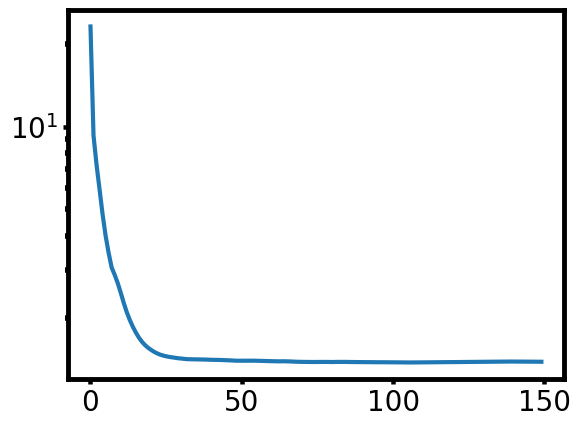

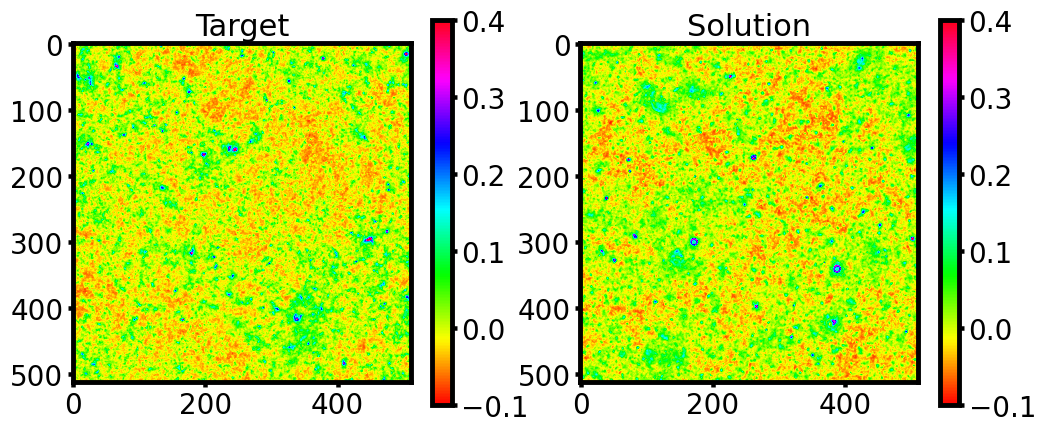

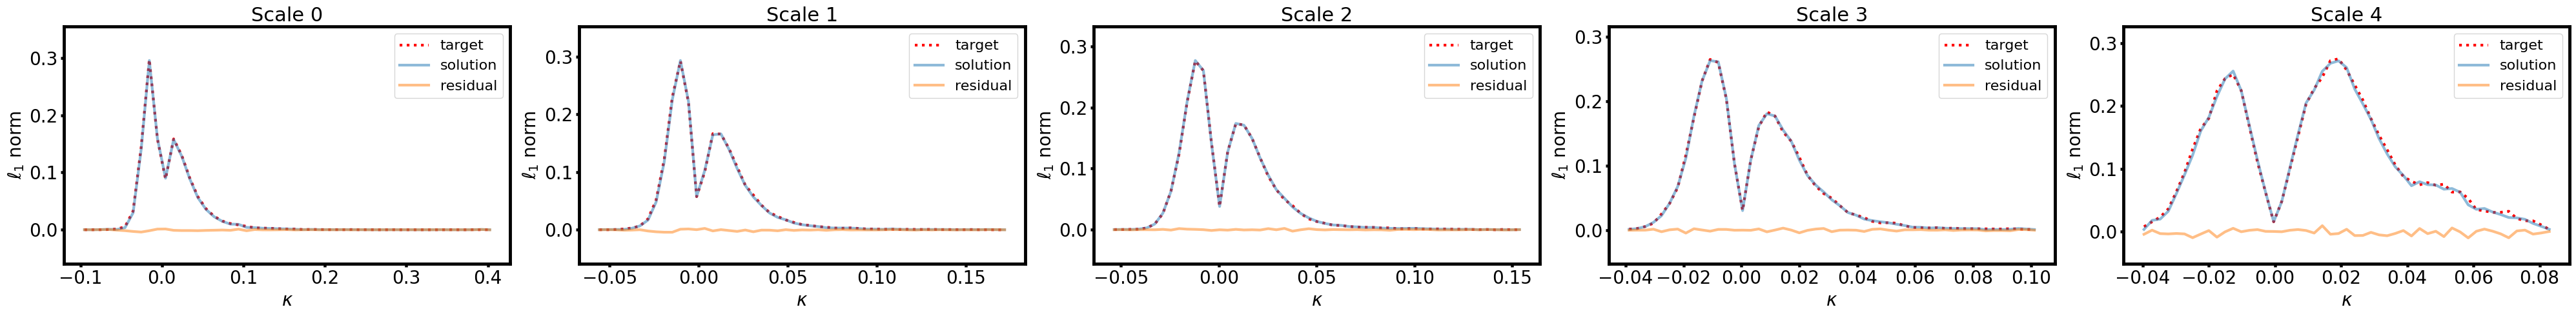

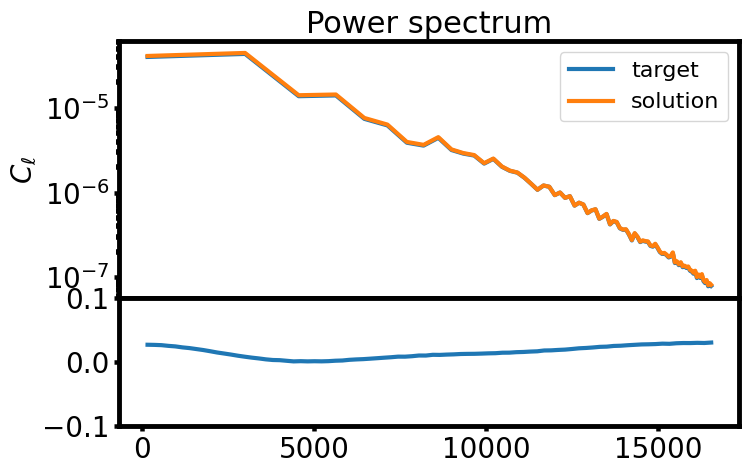

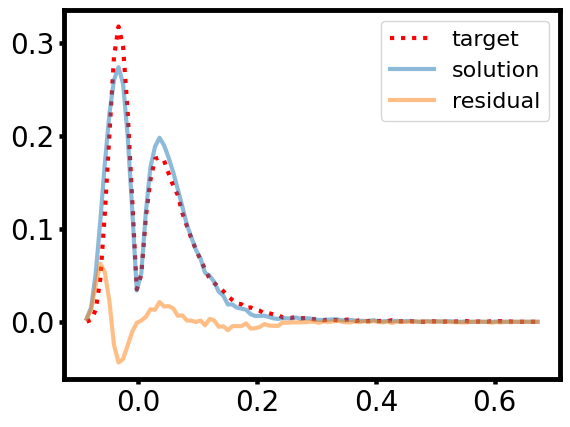

In [74]:
path = '/feynman/work/dap/lcs/vt272285/data/SLICS/2.007kappa_weight.dat_LOS400'
angle = 10
loader = SimulationDataLoader(user_defined_angle=angle) 

loaded_data, loaded_angle = loader.load_data(path)
data_downscaled = downscale_local_mean(loaded_data-np.mean(loaded_data), (4, 4))

N = 128*4
filter_type = 'tophat'
nscales = 4
print("The number of scales is: ", nscales)
nbins = [51]*(nscales+1)
target = data_downscaled[:N,:N]
pixelsize = loaded_angle.value * 60 / data_downscaled.shape[0]  # arcmin
print("the target pixelsize is: ", pixelsize)
print("the target size is: ", target.shape)

# adjuster = PowerSpectrumAdjuster(map_shape=target.shape, pixel_size=pixelsize)
# target_ells, target_cls = adjuster.compute_power_spectrum(target)

pkadjuster = PowerSpectrum(target, pixelsize)
_, target_ells, target_cls = pkadjuster.calculate_Cls(target)

decomposer = WaveletDecomposer()
density = True
target_values = process_image(target, filter_type, nscales, nbins, adjuster, decomposer, density=density)

seed = 10
np.random.seed(seed)
gaussian = np.random.normal(0., np.std(target), target.shape)

# adjuster = PowerSpectrumAdjuster(map_shape=gaussian.shape, pixel_size=pixelsize)
pkadjuster = PowerSpectrum(gaussian, pixelsize)
solution = gaussian
total_error = []

print("The number of scales is: ", nscales)
for iter in range(150):
    solution_coefs = decomposer.decompose(solution,  num_scales=nscales, filter_type=filter_type, recalculate_params=True)
    error_per_scale = 0.
    for scale in range(nscales+1):
        print(f"\r Iteration: {iter} Scale: {scale}", end="", flush=True)
        
        # solution_coefs[scale], err = adjust_map_l1(solution_coefs[scale], mask=None, targetvalues=target_values[f'scale_{scale}'], density=density)
        solution_coefs[scale], err = adjust_pixel_values(solution_coefs[scale], mask=None, targetvalues=target_values[f'scale_{scale}'], density=density) 
        error_per_scale += err
        
    total_error.append(error_per_scale)
    solution_l1 = np.sum(solution_coefs, axis=0)
    
    if iter%1 ==0:
        # solution_cl = adjuster.adjust_map_cls(solution, target_values['cls'], target_values['ells'])
        solution_cl = pkadjuster.generate_field_with_target_cls(solution,  target_cls, target_ells)

        solution =  0.5 * (solution_cl + solution_l1)
    else:
        solution = solution_l1
      
    solution = np.clip(solution, np.min(target), np.max(target))
    
plt.figure()
plt.plot(np.array(total_error)*100)
plt.yscale('log')
plt.show()

plt.figure(figsize=(12,5))
vmin = -0.1
vmax = 0.4
cmap ='hsv'
plt.subplot(1,2,1)
plt.imshow(target, vmin=vmin, vmax=vmax, cmap=cmap)
plt.title('Target')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(solution, vmin=vmin, vmax=vmax, cmap=cmap)
plt.title('Solution')
plt.colorbar()
plt.show()

solution_coefs = decomposer.decompose(solution,  num_scales=nscales, filter_type=filter_type, recalculate_params=True)

fig, axs = plt.subplots(1, nscales+1, figsize=(8*(nscales+1), 5))
for scale in range(nscales+1):
    edges_target = target_values[f'scale_{scale}']['binedges']
    centers_target = target_values[f'scale_{scale}']['bincenters']
    l1_target = target_values[f'scale_{scale}']['l1_norm']
    solution_edges, solution_centers, solution_hist, solution_l1norm = calculate_histogram_l1norm(solution_coefs[scale], mask=None, nbins=edges_target, density=density)
    
    axs[scale].plot(centers_target, l1_target, label='target', ls=":",c='r' )
    axs[scale].plot(solution_centers, solution_l1norm, label='solution', alpha=0.5)
    axs[scale].plot(centers_target,  solution_l1norm - l1_target , label='residual', alpha=0.5)
    axs[scale].legend()
    axs[scale].set_title(f'Scale {scale}')
    axs[scale].set_xlabel(r"$\kappa$")
    axs[scale].set_ylabel(r"$\ell_1$ norm")
    axs[scale].set_ylim(np.min(solution_l1norm)-(np.max(solution_l1norm)/5), np.max(solution_l1norm)+(np.max(solution_l1norm)/5))
    
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
gs = GridSpec(2, 1, height_ratios=[2, 1], hspace=0)  # hspace=0 removes vertical gapplt.subplot(gs[0])
plt.subplot(gs[0])
plt.loglog(target_ells, target_cls, label='target')
# solutionells, solutioncls = adjuster.compute_power_spectrum(solution)
_, solutionells, solutioncls = pkadjuster.calculate_Cls(solution)
plt.loglog(solutionells, solutioncls, label='solution')
plt.legend()
plt.title('Power spectrum')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')

plt.subplot(gs[1])
solution_cls_spline = CubicSpline(solutionells, solutioncls)
plt.plot(target_ells, (solution_cls_spline(target_ells) - target_cls)/target_cls, label='solution - target')
plt.ylim(-0.1, 0.1)
plt.show()

edges_target, center_target, hist_target, l1_target = calculate_histogram_l1norm(target, mask=None, nbins=100, density=density)
edges_solution, center_solution, hist_solution, l1_solution = calculate_histogram_l1norm(solution, mask=None, nbins=edges_target, density=density)

plt.figure()
plt.plot(center_target, l1_target, label='target', ls=":",c='r' )
plt.plot(center_solution, l1_solution, label='solution', alpha=0.5)
plt.plot(center_target,  l1_solution - l1_target , label='residual', alpha=0.5)
plt.legend()
plt.show()

1937 [0.30975736]


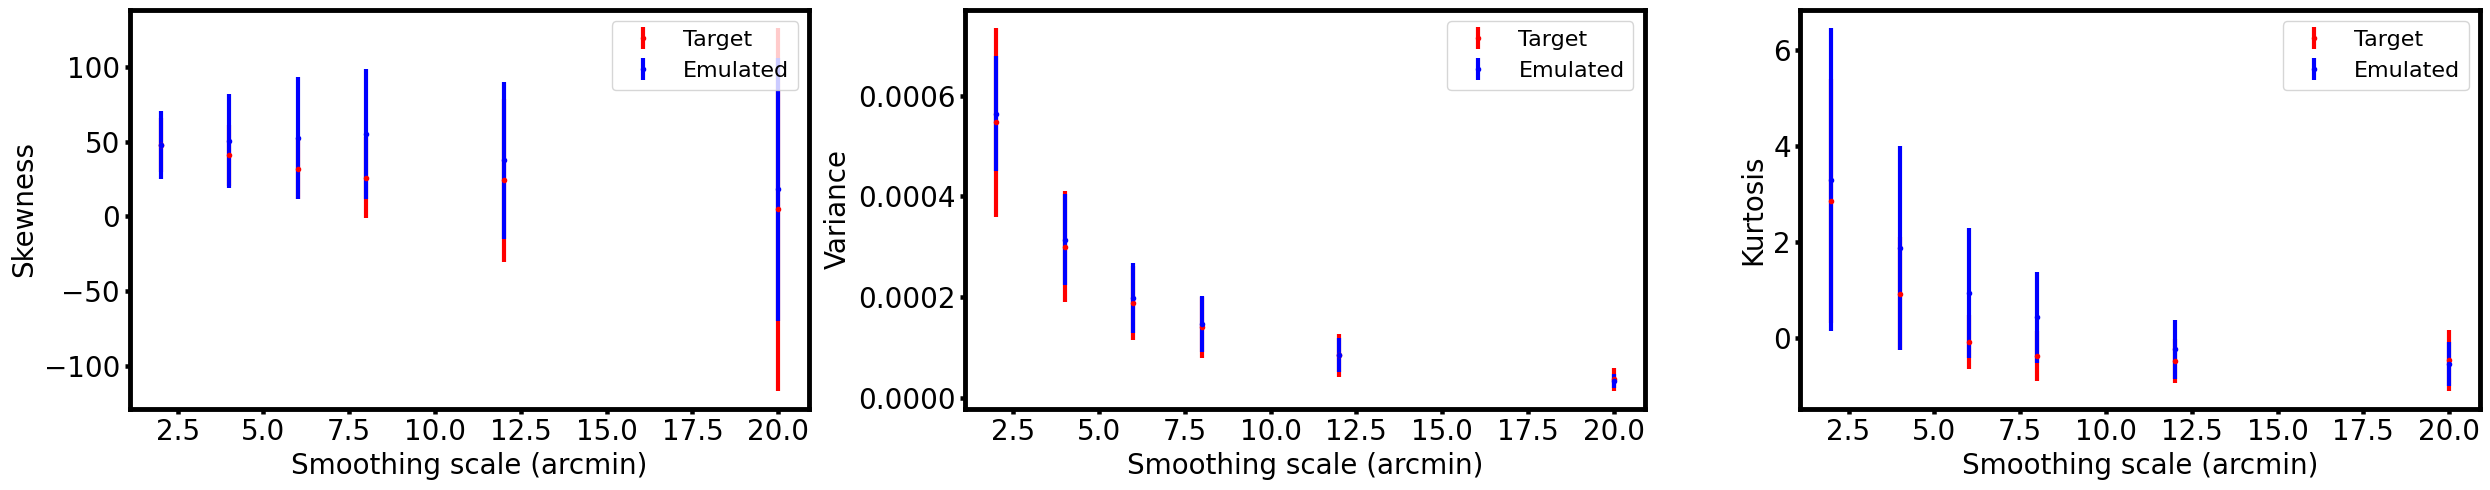

array([ 6, 12, 19, 25, 38, 64])

In [75]:
def top_hat_window_FL(k):
    return 2. * scipy.special.j1(k) / (k)

k = np.linspace(1e-16, 10000, 100000)
th = top_hat_window_FL(k)
th_interp = scipy.interpolate.interp1d(k, th, kind='cubic')

def get_W2D_FL(window_radius, map, **kwargs):
    # L = kwargs.get('L', 505)
    L = map.shape[0]
    N = map.shape[0]
    dx = L / N
    kx, ky = fftfreq(N, dx), fftfreq(N, dx)
    kx, ky = jnp.meshgrid(kx, ky, indexing='ij')
    k2 = (kx**2 + ky**2)
    k = 2 * jnp.pi * jnp.sqrt(k2)
    k = jnp.where(k == 0, 0.0000001, k)  # Avoid division by zero at the center
    return top_hat_window_FL(k * window_radius)


def get_smoothed_map(map, window_radius, **kwargs):
    L = kwargs.get('L', 505)
    W2D_1 = get_W2D_FL(window_radius, map, L = L)
    field_ft = fftn(map)
    convergence_smoothed_ft1 = field_ft * W2D_1
    convergence_smoothed = ifft2(convergence_smoothed_ft1).real
    return convergence_smoothed

def get_moments_from_map(map_values):
    """
    Calculates the moments (mean, variance, skewness, kurtosis) from a 2D map.

    Parameters:
        map_values (numpy.ndarray): A 2D array representing the map values (e.g., convergence, density field).

    Returns:
        tuple: Contains mean, variance, skewness, kurtosis of the map values.
    """
    # Flatten the map to treat it as a distribution of values
    flattened_values = map_values.flatten()

    # Calculate the mean
    mean_value = np.mean(flattened_values)

    # Calculate the variance (second central moment)
    variance = np.var(flattened_values)

    # Calculate the third moment (skewness numerator)
    third_moment = np.mean((flattened_values - mean_value) ** 3)

    # Calculate the fourth moment (kurtosis numerator)
    fourth_moment = np.mean((flattened_values - mean_value) ** 4)

    # Skewness: third moment divided by variance squared
    skewness = third_moment / (variance ** 2)

    # Kurtosis: fourth moment divided by variance squared, minus 3 for excess kurtosis
    kurtosis = (fourth_moment / (variance ** 2)) - 3.0

    return mean_value, variance, skewness, kurtosis

def split_image_into_patches(image, num_patches):
    # Get the height and width of the image
    n = image.shape[0]
    
    # Calculate the patch size (assuming n is divisible by the square root of num_patches)
    patch_size = int( n // num_patches    )
    
    # Check if num_patches is a perfect square and the image can be divided equally
    # if n % patch_size != 0 or num_patches != (n // patch_size) ** 2:
    #     raise ValueError("The image size and number of patches do not match for equal division.")

    # Split the image into patches
    patches = []
    for i in range(0, n, patch_size):
        for j in range(0, n, patch_size):
            patch = image[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    
    return patches

N_mesh = data_downscaled.shape[0]
target_image = target
final_map = solution
L = 505
degsize=np.array([10]) #degree 
pixsize=degsize*60/N_mesh #arcmin
print(N_mesh, pixsize)

theta1 = np.array([2, 4,  6,  8,  12, 20]) 
theta1_pixels = (theta1/pixsize).astype(int)

fig, axs = plt.subplots(1, 3, figsize=(25, 5))
# Flags to control labeling in the legend
first_label_target = True
first_label_emulated = True

for i, theta1s in enumerate(theta1_pixels):
    emulated_smoothed = get_smoothed_map(final_map, theta1s) 
    target_smoothed = get_smoothed_map(target_image, theta1s) 
    emu_patches = split_image_into_patches(emulated_smoothed, 4)
    tar_patches = split_image_into_patches(target_smoothed, 4)
    
    emu_mean = []
    emu_variance = []
    emu_skewness = []
    emu_kurtosis = []
    tar_mean = []
    tar_variance = []
    tar_skewness = []
    tar_kurtosis = []
    for no_patch in range(len(emu_patches)):
        emulated_mean, emulated_variance, emulated_skewness, emulated_kurtosis = get_moments_from_map(emu_patches[no_patch])
        target_mean, target_variance, target_skewness, target_kurtosis = get_moments_from_map(tar_patches[no_patch])
        emu_mean.append(emulated_mean)
        emu_variance.append(emulated_variance)
        emu_skewness.append(emulated_skewness)
        emu_kurtosis.append(emulated_kurtosis)
        tar_mean.append(target_mean)
        tar_variance.append(target_variance)
        tar_skewness.append(target_skewness)
        tar_kurtosis.append(target_kurtosis)
    
    
    axs[0].errorbar(theta1[i], np.average(tar_skewness), yerr=np.std(tar_skewness), c='r', label='Target' if first_label_target else "", fmt='o')
    axs[0].errorbar(theta1[i], np.average(emu_skewness), yerr=np.std(emu_skewness),fmt='o', c='b')
    axs[0].set_xlabel("Smoothing scale (arcmin)")
    axs[0].set_ylabel("Skewness")
    
    axs[1].errorbar(theta1[i], np.average(tar_variance),yerr=np.std(tar_variance),fmt='o', c='r', label='Target' if first_label_target else "")
    axs[1].errorbar(theta1[i], np.average(emu_variance),yerr=np.std(emu_variance),fmt='o', c='b')
    axs[1].set_xlabel("Smoothing scale (arcmin)")
    axs[1].set_ylabel("Variance")
    
    axs[2].errorbar(theta1[i], np.average(tar_kurtosis), c='r', yerr=np.std(tar_kurtosis), fmt='o',label='Target' if first_label_target else "")
    axs[2].errorbar(theta1[i], np.average(emu_kurtosis), yerr=np.std(emu_kurtosis), fmt='o', c='b')
    axs[2].set_xlabel("Smoothing scale (arcmin)")
    axs[2].set_ylabel("Kurtosis")
   
# Fetch unique handles and labels after plotting
handles_skewness, labels_skewness = axs[0].get_legend_handles_labels()
handles_variance, labels_variance = axs[1].get_legend_handles_labels()
handles_kurtosis, labels_variance = axs[2].get_legend_handles_labels()

# Create legends
axs[0].legend(['Target', 'Emulated'], loc='best')
axs[1].legend(['Target', 'Emulated'], loc='best')
axs[2].legend(['Target', 'Emulated'], loc='best')


plt.tight_layout()
plt.show()

# fig, axs = plt.subplots(2, len(theta1), figsize=(35, 15)) 

# for i, theta1s in enumerate(theta1_pixels):
#     emulated_smoothed = get_smoothed_map(final_map, theta1s) 
#     target_smoothed = get_smoothed_map(target_image, theta1s) 
    
#     edges_emulated, bin_centers_emulated, counts_emulated = calculate_pdf(emulated_smoothed, 150)
#     edges_target, bin_centers_target, counts_target = calculate_pdf(target_smoothed, edges_emulated) 
#     axs[0,i].plot(bin_centers_target, counts_target, label=theta1[i])
#     axs[0,i].plot(bin_centers_emulated, counts_emulated, ls=":")
#     axs[0,i].set_yscale('log')
#     axs[0,i].legend()
    
#     axs[1,i].plot(bin_centers_target, (counts_emulated/counts_target) - 1, label=theta1[i])
#     axs[1,i].set_ylim(-0.1,0.1)
#     axs[1,i].set_xlim(np.mean(emulated_smoothed)-1.5*np.std(emulated_smoothed), np.mean(emulated_smoothed)+1.5*np.std(emulated_smoothed))
    
# plt.tight_layout()
# plt.show() 
   


theta1_pixels